In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tensorflow as tf

from edward.models import Bernoulli, Normal

In [2]:
class FLAGS:
    N=40   # Number of data points
    D=1    # Number of features
    T=5000 # Number of posterior samples

In [3]:
def build_toy_dataset(N, noise_std=0.1):
    D = 1
    X = np.linspace(-6, 6, num=N)
    y = np.tanh(X) + np.random.normal(0, noise_std, size=N)
    y[y < 0.5] = 0
    y[y >= 0.5] = 1
    X = (X - 4.0) / 4.0
    X = X.reshape((N, D))
    return X, y

In [4]:
ed.set_seed(42)

# DATA
X_train, y_train = build_toy_dataset(FLAGS.N)

# MODEL
X = tf.placeholder(tf.float32, [FLAGS.N, FLAGS.D])
w = Normal(loc=tf.zeros(FLAGS.D), scale=3.0 * tf.ones(FLAGS.D))
b = Normal(loc=tf.zeros([1]), scale=3.0 * tf.ones([1]))
y = Bernoulli(logits=ed.dot(X, w) + b)

# INFERENCE
# qw = Empirical(params=tf.get_variable("qw/params", [FLAGS.T, FLAGS.D]))
# qb = Empirical(params=tf.get_variable("qb/params", [FLAGS.T]))

# inference = ed.HMC({w: qw, b: qb}, data={X: X_train, y: y_train})
# inference.initialize(n_print=10, step_size=0.6)

# Alternatively, use variational inference.
qw_loc = tf.get_variable("qw_loc", [FLAGS.D])
qw_scale = tf.nn.softplus(tf.get_variable("qw_scale", [FLAGS.D]))
qb_loc = tf.get_variable("qb_loc", [1]) + 10.0
qb_scale = tf.nn.softplus(tf.get_variable("qb_scale", [1]))

qw = Normal(loc=qw_loc, scale=qw_scale)
qb = Normal(loc=qb_loc, scale=qb_scale)

# inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference = ed.Laplace({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.initialize(n_print=10, n_iter=600)

inference.run()


/Users/cyz/edward/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 10.629


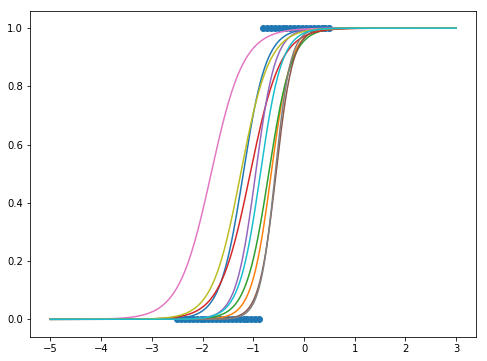

In [7]:
n_posterior_samples = 10

w_post = qw.sample(n_posterior_samples).eval()
b_post = qb.sample(n_posterior_samples).eval()

plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(X_train, y_train)

inputs = np.linspace(-5, 3, num=400)
for ns in range(n_posterior_samples):
    output = scipy.special.expit(np.dot(inputs[:,np.newaxis], w_post[ns]) + b_post[ns])
    plt.plot(inputs, output)

plt.show()

In [12]:
qw.scale.eval()

array([0.9400087], dtype=float32)

In [15]:
qw.loc.eval()

array([4.8467326], dtype=float32)

In [16]:
qb.scale.eval()

array([0.88841593], dtype=float32)

In [17]:
qb.loc.eval()

array([3.93611], dtype=float32)